# Fastai library setup

In [3]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0 MB 7.8 kB/s  eta 0:00:01     |███████▍                        | 164.1 MB 47.2 MB/s eta 0:00:12     |███████▋                        | 167.6 MB 47.2 MB/s eta 0:00:12     |███████▉                        | 172.6 MB 47.2 MB/s eta 0:00:12     |████████                        | 178.9 MB 47.2 MB/s eta 0:00:12     |████████▏                       | 180.6 MB 47.2 MB/s eta 0:00:12     |████████▎                       | 182.2 MB 47.2 MB/s eta 0:00:12MB 47.2 MB/s eta 0:00:12     |████████▋                       | 190.4 MB 11.1 MB/s eta 0:00:47     |████████████▋                   | 277.8 MB 26.2 MB/s eta 0:00:17     |████████████▊                   | 281.3 MB 26.2 MB/s eta 0:00:17     |███████████████████████▋        | 523.4 MB 42.2 MB/s eta 0:00:05     |███████████████████████▉        | 526.8 MB 42.2 MB/s eta 0:00:05     |████████████████████████        | 530.8 MB 42.2 MB/s eta 0:00

In [4]:
!pip install --upgrade kornia
!pip install allennlp==1.1.0.rc4

Requirement already up-to-date: kornia in /opt/conda/lib/python3.7/site-packages (0.4.0)
     |████████████████████████████████| 484 kB 359 kB/s eta 0:00:01
  Attempting uninstall: allennlp


    Found existing installation: allennlp 1.1.0
    Uninstalling allennlp-1.1.0:
      Successfully uninstalled allennlp-1.1.0


In [5]:
!pip install --upgrade fastai

Requirement already up-to-date: fastai in /opt/conda/lib/python3.7/site-packages (2.0.13)


In [6]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

import fastai
print(fastai.__version__)

from fastai.vision.all import *

1.6.0+cu101
True
2.0.13


# EDA

In [7]:
path = Path('../input/jovian-pytorch-z2g/Human protein atlas')
Path.BASE_PATH = path
path.ls()

(#3) [Path('train.csv'),Path('train'),Path('test')]

In [8]:
train = pd.read_csv(path/'train.csv')
test = pd.read_csv('../input/jovian-pytorch-z2g/submission.csv')
print('----training------')
print(train.head())
print('-------testing--------')
print(test.head())
print('Shape of training data is {} and testing data is {}'.format(train.shape, test.shape))

----training------
   Image Label
0  19567     9
1  29993   6 4
2  17186   1 4
3  29600   6 2
4    701   3 4
-------testing--------
   Image  Label
0  24117      0
1  15322      0
2  14546      0
3   8079      0
4  13192      0
Shape of training data is (19236, 2) and testing data is (8243, 2)


In [9]:
train_img = get_image_files(path/'train')
test_img = get_image_files(path/'test')
print('Number of training images are {} and testing images are {}'.format(len(train_img), len(test_img)))

Number of training images are 19236 and testing images are 8243


# Helper Functions

In [10]:
train['img_path'] = train['Image'].apply(lambda x: '../input/jovian-pytorch-z2g/Human protein atlas/train/{}.png'.format(x))

In [11]:

labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

indexes = {str(v):k for k,v in labels.items()}


def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

# Datasets and Dataloaders

In [12]:
def get_x(df): return df['img_path']
def get_y(df): return [labels[int(l)] for l in df['Label'].split()]

In [13]:
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=get_x, get_y=get_y,
    splitter=RandomSplitter(),
    item_tfms=Resize(224))

In [14]:
dls = dblock.dataloaders(train)

In [15]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 10]))

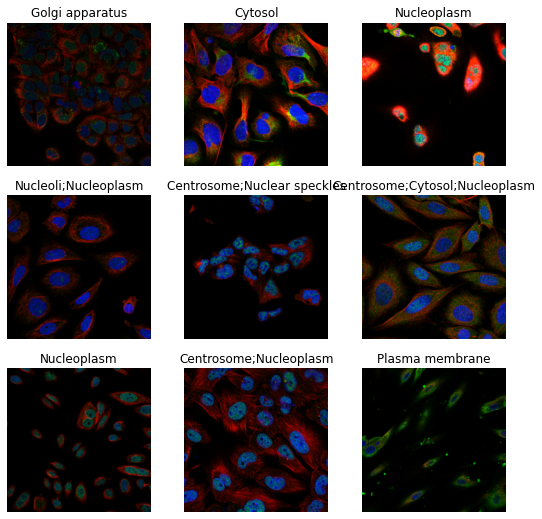

In [16]:
dls.show_batch()

In [17]:
learn = cnn_learner(dls, resnet34, metrics=accuracy_multi)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [18]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.480790,0.340769,0.871900,03:30


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.340308,0.306239,0.883728,03:08
1,0.282946,0.288915,0.889342,03:06


In [21]:
learn = cnn_learner(dls, resnet34, metrics=[accuracy_multi, F1ScoreMulti()])
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.478070,0.341283,0.872082,0.176189,03:03


epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.331675,0.301901,0.884481,0.261663,03:05
